# FINAL PROJECT: Portfolio Optimization using Sharpe Ratio

Fall 2025

[MATH204] Introduction to Quantitative Finance

Course Instructor: Le Tan


Group 2

Team members:

*   Vu Thi Khanh Ngoc
*   Nguyen Thi Thanh Mai
*   Ngo Nhi
*   Nguyen Le Na
*   Vi Thi Thu Ha






In [ ]:
# Google Colab setup command to install PyPortfolioOpt
!pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git

In [2]:
# Import necessary libraries:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models, plotting
from pypfopt.objective_functions import L2_reg
from pypfopt import EfficientFrontier, risk_models, expected_returns

## Data Preparation

### Merge into one DataFrame

In [4]:
# Read all dataset

# Google Colab file paths 
# bond = pd.read_csv("/content/bond_yield_daily.csv")
# stock = pd.read_csv("/content/stock_index_daily.csv")
# gold = pd.read_csv("/content/gold_prices_daily.csv")

# Local file paths
bond = pd.read_csv("data/bond_yield_daily.csv")
stock = pd.read_csv("data/stock_index_daily.csv")
gold = pd.read_csv("data/gold_prices_daily.csv")

In [5]:
# Check if there exists NaN values
print(bond.isna().sum())
print(stock.isna().sum())
print(gold.isna().sum())

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
% Thay đổi    0
dtype: int64
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
date              0
gold_price_vnd    0
dtype: int64


In [6]:
# Reverse the order
bond = bond.iloc[::-1].reset_index(drop=True)
stock = stock.iloc[::-1].reset_index(drop=True)

# Bond & Stock have date format: "01/10/2025" (day/month/year)
bond['date'] = pd.to_datetime(bond['Ngày'], format="%d/%m/%Y", errors='coerce')
stock['date'] = pd.to_datetime(stock['Ngày'], format="%d/%m/%Y", errors='coerce')

# Gold has format: "2025-08-15" (year-month-day)
gold['date'] = pd.to_datetime(gold['date'], format="%Y-%m-%d")

# Remove currency symbol and thousand separators
gold['gold_price_vnd'] = (
    gold['gold_price_vnd']
    .astype(str)
    .str.replace('₫', '', regex=False)
    .str.replace(',', '', regex=False)   # REMOVE COMMAS
    .str.strip()                         # remove any extra spaces
)

# Convert data values to numeric
bond['Lần cuối'] = pd.to_numeric(bond['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
stock['Lần cuối'] = pd.to_numeric(stock['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
gold['gold_price_vnd'] = pd.to_numeric(gold['gold_price_vnd'], errors='coerce')

In [8]:
# Compute montly average for each asset
# Create an addition column & filter only month and year
bond['month_year'] = bond['date'].dt.to_period("M")
stock['month_year'] = stock['date'].dt.to_period("M")
gold['month_year'] = gold['date'].dt.to_period("M")

# Compute mean
bond_monthly = bond.groupby("month_year")['Lần cuối'].mean().reset_index()
stock_monthly = stock.groupby("month_year")['Lần cuối'].mean().reset_index()
gold_monthly = gold.groupby("month_year")['gold_price_vnd'].mean().reset_index()

bond_monthly = bond_monthly.rename(columns={"Lần cuối": "bond_yield"})
stock_monthly = stock_monthly.rename(columns={"Lần cuối": "stock_index"})

In [9]:
# Merge into one data frame
df = gold_monthly.merge(bond_monthly, on="month_year", how="outer") \
                 .merge(stock_monthly, on="month_year", how="outer")

df['month_year'] = df['month_year'].astype(str)

df = df.iloc[:-1]

print(df)

    month_year  gold_price_vnd  bond_yield  stock_index
0      2015-10    2.584734e+07    7.034208   589.446818
1      2015-11    2.432134e+07    7.073727   602.326667
2      2015-12    2.405079e+07    7.059652   569.667826
3      2016-01    2.457863e+07    7.056091   548.304500
4      2016-02    2.682969e+07    7.007045   551.670000
..         ...             ...         ...          ...
115    2025-05    8.541415e+07    3.191600  1301.096000
116    2025-06    8.746790e+07    3.281429  1343.840476
117    2025-07    8.737124e+07    3.381652  1465.106957
118    2025-08    8.855705e+07    3.564571  1619.252381
119    2025-09    9.680589e+07    3.702182  1660.869500

[120 rows x 4 columns]


### Take log return of monthly asset price

Log returns are computed using:

$$
\ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $P_t$ is the price at time $t$
- $P_{t-1}$ is the price in the previous period


In [10]:
df_returns = df.copy()

# Compute log returns
df_returns['gold_log_return'] = np.log(df_returns['gold_price_vnd'] / df_returns['gold_price_vnd'].shift(1))
df_returns['bond_log_return'] = np.log(df_returns['bond_yield'] / df_returns['bond_yield'].shift(1))
df_returns['stock_log_return'] = np.log(df_returns['stock_index'] / df_returns['stock_index'].shift(1))

# Drop the first row (NaN from shift)
df_returns = df_returns.dropna().reset_index(drop=True)

print(df_returns.head())

  month_year  gold_price_vnd  bond_yield  stock_index  gold_log_return  \
0    2015-11    2.432134e+07    7.073727   602.326667        -0.060853   
1    2015-12    2.405079e+07    7.059652   569.667826        -0.011187   
2    2016-01    2.457863e+07    7.056091   548.304500         0.021710   
3    2016-02    2.682969e+07    7.007045   551.670000         0.087632   
4    2016-03    2.773421e+07    6.872565   572.673913         0.033158   

   bond_log_return  stock_log_return  
0         0.005602          0.021615  
1        -0.001992         -0.055747  
2        -0.000505         -0.038223  
3        -0.006975          0.006119  
4        -0.019379          0.037366  


### Annualize


$$
\text{Annualized Mean Return} = \text{Mean Monthly Return} \times 12
$$


$$
\text{Annual Covariance} = \text{Monthly Covariance} \times 12
$$


$$
\text{Annual Standard Deviation} = \text{Monthly Standard Deviation} \times \sqrt{12}
$$


In [11]:
# Select log return columns
returns = df_returns[['gold_log_return', 'bond_log_return', 'stock_log_return']]

# Annualize mean return vector
mean_return_annual = returns.mean() * 12

# Annualize covariance matrix
cov_matrix_annual = returns.cov() * 12

# Annualize
std_annual = returns.std() * np.sqrt(12)

print("Annualized Mean Return Vector:")
print(mean_return_annual)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)

print("\nAnnualized Standard Deviation:")
print(std_annual)


Annualized Mean Return Vector:
gold_log_return     0.133160
bond_log_return    -0.064726
stock_log_return    0.104462
dtype: float64

Annualized Covariance Matrix:
                  gold_log_return  bond_log_return  stock_log_return
gold_log_return          0.011945         0.000737          0.000488
bond_log_return          0.000737         0.042217         -0.010203
stock_log_return         0.000488        -0.010203          0.027454

Annualized Standard Deviation:
gold_log_return     0.109295
bond_log_return     0.205467
stock_log_return    0.165693
dtype: float64


# QUESTION 1: Which types of assets have the highest Sharpe ratio in Vietnam?

$$
\text{Sharpe Ratio} = \frac{\mu_{\text{annual}} - R_f}{\sigma_{\text{annual}}},
\quad \text{where}
\quad
\begin{aligned}
\mu_{\text{annual}} &= \text{annualized mean log return} = \text{mean of monthly log returns} \times 12, \\
\sigma_{\text{annual}} &= \text{annualized standard deviation of log returns} = \text{standard deviation of monthly log returns} \times \sqrt{12}, \\
R_f &= \text{annual risk-free rate}.
\end{aligned}
$$


In [12]:
# Risk-free rate
rf_annual = 0.04

# Sharpe ratio
sharpe_annual = (mean_return_annual - rf_annual) / std_annual

# Build table
stats_table = pd.DataFrame({
    "Gold": [mean_return_annual["gold_log_return"], std_annual["gold_log_return"], sharpe_annual["gold_log_return"]],
    "Bond": [mean_return_annual["bond_log_return"], std_annual["bond_log_return"], sharpe_annual["bond_log_return"]],
    "Stock": [mean_return_annual["stock_log_return"], std_annual["stock_log_return"], sharpe_annual["stock_log_return"]],
},
index=["Mean p.a.", "SD p.a.", "Sharpe ratio p.a."]
)

stats_table

,Gold,Bond,Stock
Mean p.a.,0.133160,-0.064726,0.104462
SD p.a.,0.109295,0.205467,0.165693
Sharpe ratio p.a.,0.852369,-0.509695,0.389044


## QUESTION 2: Efficient frontiers based on 2 cases of constraints




**Objective:** Maximize the Sharpe ratio of a portfolio including the risk-free rate $R_f$:

$$
\max_{w} \text{Sharpe Ratio}(w) = \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}}
$$


Source: https://bookdown.org/palomar/portfoliooptimizationbook/7.2-MSRP.html


**Where:**  
- $w = [w_1, w_2, \dots, w_n]^T$ is the vector of portfolio weights  
- $\mu = [\mu_1, \mu_2, \dots, \mu_n]^T$ is the vector of expected annual returns of the assets  
- $\Sigma$ is the covariance matrix of asset returns  
- $R_f$ is the annual risk-free rate  

**Constraints:**  
1. Portfolio weights sum to 1:  
$$
\sum_{i=1}^{n} w_i = 1
$$  
2. Long-only portfolio (no short selling):  
$$
0 \le w_i \le 1, \quad i = 1, \dots, n
$$


### Case 1: Baseline model

*   Applying 2 constraints above
*   No weight allocation constraints









In [13]:
# mean return vector and covariance matrix from your data
mu = mean_return_annual.values        # array of expected returns
Sigma = cov_matrix_annual.values      # covariance matrix

# Number of assets
n = len(mu)

# Objective function: negative simplified Sharpe Ratio
# We negate it because minimize minimizes a function, but we want to maximize the Sharpe ratio.
def neg_sharpe(w, mu, Sigma):
    return - (w @ mu - rf_annual) / np.sqrt(w @ Sigma @ w)

# Constraints: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: long-only (0 <= w_i <= 1)
bounds = tuple((0, 1) for _ in range(n))

# Initial guess (equal weights)
w0 = np.array([1/n]*n)

# Optimize
result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
w_opt = result.x
print("Optimal Weights:", w_opt)
print("Maximum Simplified Sharpe Ratio:", -result.fun)

Optimal Weights: [7.77437229e-01 9.40968307e-18 2.22562771e-01]
Maximum Simplified Sharpe Ratio: 0.9277041114979175


Expected annual return: 8.3%
Annual volatility: 7.9%
Sharpe Ratio: 0.80
Expected annual return: 12.7%
Annual volatility: 9.4%
Sharpe Ratio: 0.93


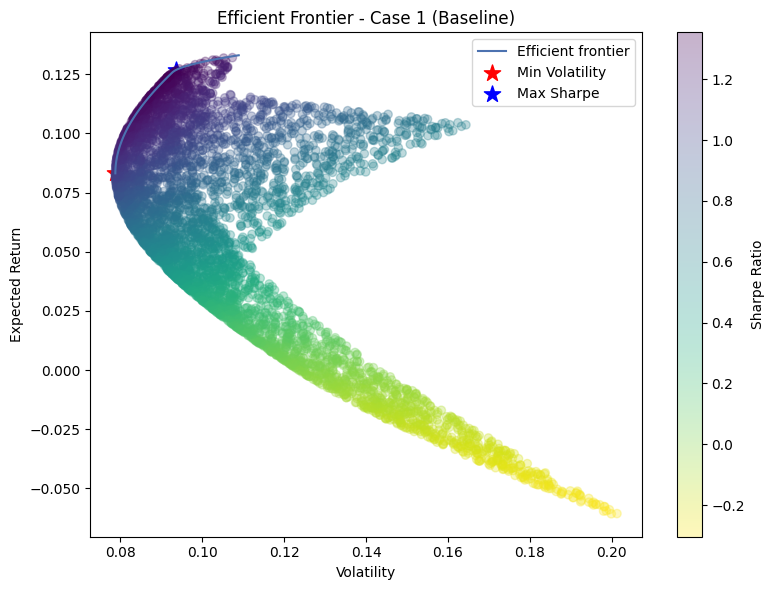

In [15]:
ef_case1 = EfficientFrontier(mu, Sigma)  # Full investment + long-only

# Minimum volatility
ef_min_vol_case1 = ef_case1.deepcopy()
weights_min_vol_case1 = ef_min_vol_case1.min_volatility()
ret_min_vol1, std_min_vol1, _ = ef_min_vol_case1.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case1 = ef_case1.deepcopy()
weights_max_sharpe_case1 = ef_max_sharpe_case1.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe1, std_max_sharpe1, _ = ef_max_sharpe_case1.portfolio_performance(verbose=True)

fig1, ax1 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case1, ax=ax1, show_assets=False)

# Highlight portfolios
ax1.scatter(std_min_vol1, ret_min_vol1, marker="*", s=150, c="red", label="Min Volatility")
ax1.scatter(std_max_sharpe1, ret_max_sharpe1, marker="*", s=150, c="blue", label="Max Sharpe")

# Random portfolios
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = rets_random / stds_random
sc = ax1.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc, ax=ax1)
cbar.set_label("Sharpe Ratio")
ax1.set_xlabel("Volatility")
ax1.set_ylabel("Expected Return")
ax1.set_title("Efficient Frontier - Case 1 (Baseline)")
ax1.legend()
plt.tight_layout()
plt.show()

### Case 2: Gold minimum x Bonds maximum (include weight allocation constraints)

*   Gold_min = 5%
*   Bond_max = 30%







In [16]:
# Identify index for Gold and Bond
# Assuming order: [Gold, Bond, Stock]
idx_gold = 0
idx_bond = 1

# Objective function: negative simplified Sharpe Ratio
def neg_sharpe(w, mu, Sigma):
    return - (w @ mu - rf_annual) / np.sqrt(w @ Sigma @ w)

# Constraints:

# 1. Full investment
cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Bounds for each asset
# Long-only: 0 <= w_i <= 1
bounds = [(0,1) for _ in range(n)]

# 2. Gold minimum 5%
bounds[idx_gold] = (0.50, 1)

# 3. Bond maximum 30%
bounds[idx_bond] = (0, 0.30)

# Initial guess (equal weights within bounds)
w0 = np.array([0.33, 0.33, 0.34])
w0[idx_gold] = max(w0[idx_gold], 0.05)
w0[idx_bond] = min(w0[idx_bond], 0.30)
w0 = w0 / np.sum(w0)  # normalize to sum to 1

# Optimize
result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)

# Optimal weights
w_opt = result.x
print("Optimal Weights (Case 2):", w_opt)
print("Maximum Simplified Sharpe Ratio (Case 2):", -result.fun)

Optimal Weights (Case 2): [7.77140012e-01 7.13606794e-17 2.22859988e-01]
Maximum Simplified Sharpe Ratio (Case 2): 0.927704321173685


Expected annual return: 11.9%
Annual volatility: 8.9%
Sharpe Ratio: 1.11
Expected annual return: 12.7%
Annual volatility: 9.4%
Sharpe Ratio: 0.93


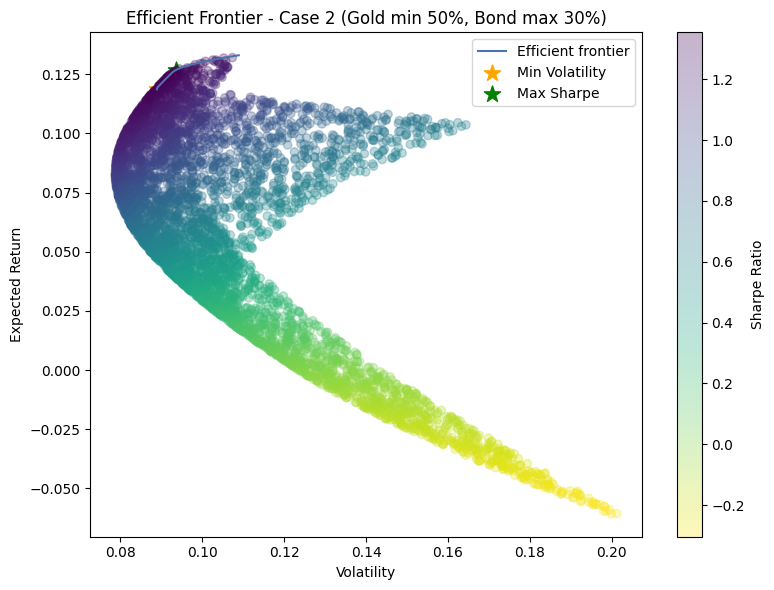

In [17]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.03)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility")
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe")

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 13.2%
Annual volatility: 10.7%
Sharpe Ratio: 1.04
Expected annual return: 13.3%
Annual volatility: 10.7%
Sharpe Ratio: 0.86


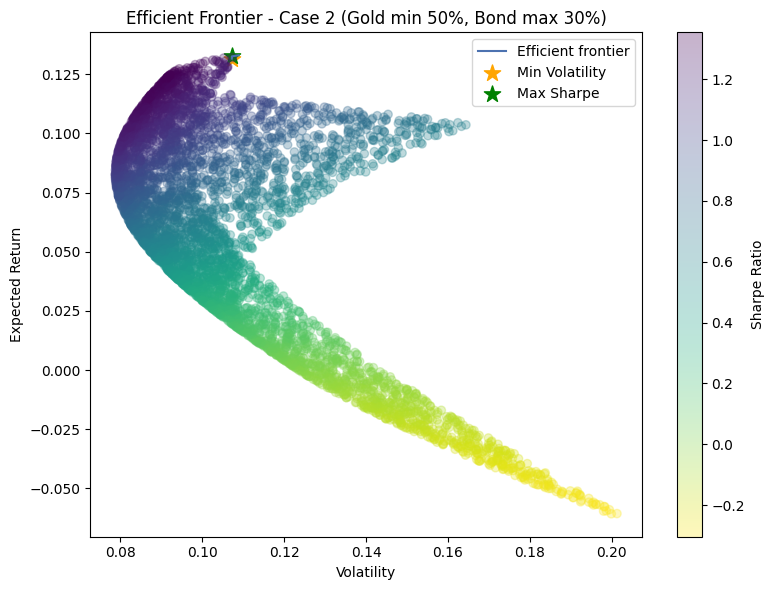

In [18]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.98)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.02)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility")
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe")

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 4.8%
Annual volatility: 9.2%
Sharpe Ratio: 0.31
Expected annual return: 5.1%
Annual volatility: 9.8%
Sharpe Ratio: 0.11


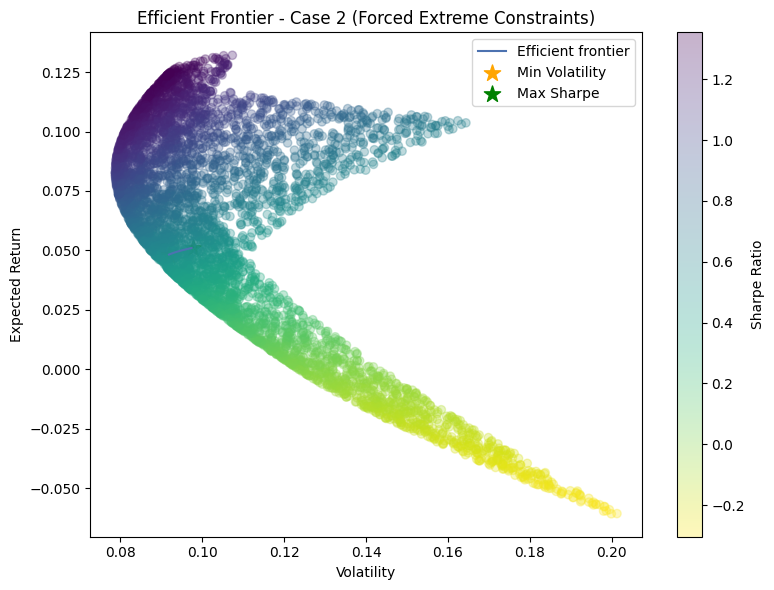

In [19]:
ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

# Constraints:
ef_case2.add_constraint(lambda w: w[0] <= 0.50)  # Gold <= 50%
ef_case2.add_constraint(lambda w: w[1] >= 0.40)  # Bond >= 40%
ef_case2.add_constraint(lambda w: w[2] <= 0.20)  # Stock <= 20%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(verbose=True)

# ---------------- PLOT ----------------
fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility")
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe")

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Forced Extreme Constraints)")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Case 1: Maximum Sharpe Ratio weights
print("Maximum Sharpe Ratio Weights (Case 1):")
for asset, weight in zip(['Gold', 'Bond', 'Stock'], weights_max_sharpe_case1.values()):
    print(f"{asset}: {weight:.2%}")

# Case 1: Minimum Volatility weights
print("\nMinimum Volatility Weights (Case 1):")
for asset, weight in zip(['Gold', 'Bond', 'Stock'], weights_min_vol_case1.values()):
    print(f"{asset}: {weight:.2%}")

# Check against Case 2 constraints
gold_constraint = 0.50
bond_constraint = 0.30

print("\nDo the Case 1 weights satisfy Case 2 constraints?")
print(f"Max Sharpe - Gold >= 50%? {'Yes' if list(weights_max_sharpe_case1.values())[0] >= gold_constraint else 'No'}")
print(f"Max Sharpe - Bond <= 30%? {'Yes' if list(weights_max_sharpe_case1.values())[1] <= bond_constraint else 'No'}")
print(f"Min Vol - Gold >= 50%? {'Yes' if list(weights_min_vol_case1.values())[0] >= gold_constraint else 'No'}")
print(f"Min Vol - Bond <= 30%? {'Yes' if list(weights_min_vol_case1.values())[1] <= bond_constraint else 'No'}")


Maximum Sharpe Ratio Weights (Case 1):
Gold: 77.71%
Bond: 0.00%
Stock: 22.29%

Minimum Volatility Weights (Case 1):
Gold: 49.48%
Bond: 20.98%
Stock: 29.54%

Do the Case 1 weights satisfy Case 2 constraints?
Max Sharpe - Gold >= 50%? Yes
Max Sharpe - Bond <= 30%? Yes
Min Vol - Gold >= 50%? No
Min Vol - Bond <= 30%? Yes


* The Max Sharpe portfolio is already “naturally” compliant with the new constraints.
* The Min Vol portfolio is very close to the constraints, so imposing them barely changes the outcome.
* That’s why your results from the two codes are nearly identical.